# Map with various levels of compression comparing round+lossless and zfp

In [1]:
using BitInformation
using PyPlot
using ColorSchemes
using StatsBase, Statistics
using NetCDF
using PyCall
ccrs = pyimport("cartopy.crs");

In [2]:
# initialise compression methods
using ZfpCompression
using TranscodingStreams, CodecZstd

ZstdCompressorL3 = ZstdCompressor(level=3)
TranscodingStreams.initialize(ZstdCompressorL3)

ZstdCompressorL10 = ZstdCompressor(level=10)
TranscodingStreams.initialize(ZstdCompressorL10)

ZstdCompressorL12 = ZstdCompressor(level=12)
TranscodingStreams.initialize(ZstdCompressorL12)

ZstdCompressorL22 = ZstdCompressor(level=22)
TranscodingStreams.initialize(ZstdCompressorL22)

In [3]:
# find file
path = "/network/aopp/chaos/pred/kloewer/esowc/cams/"
filelist = filter(x->endswith(x,"_v3.nc"),readdir(path))
varname = "q"
file = filelist[[occursin(varname,f) for f in filelist]][1]

# load file
ncfile = NetCDF.open(joinpath(path,file))
X = ncfile.vars[varname][:,:,:]
lat = ncfile.vars["lat"][:]
lon = ncfile.vars["lon"][:]

level = 110
Xlev = X[:,:,level];

## BITWISE INFORMATION

In [4]:
bitinf = bitinformation(Xlev,:all_dimensions)
inf_thresh = 1.1*maximum(bitinf[end-7:end])
bitinf_filt = copy(bitinf)
bitinf_filt[bitinf_filt .< inf_thresh] .= 0
total_information = sum(bitinf_filt)

2.815947329886926

In [5]:
keepbits100 = argmax(bitinf_filt[9:end] .== 0)
which_keepbits(p) = argmax(cumsum(bitinf_filt)/total_information .>= p) - 9
keepbits_zstd = vcat(keepbits100,which_keepbits.([0.999,0.99,0.95,0.90,0.75]))

6-element Vector{Int64}:
 10
  5
  3
  2
  1
  0

## ROUND + ZSTD COMPRESSION

In [6]:
compfacs_zstd = fill(0.0,length(keepbits_zstd))     # compression factors
compfacs_zfp_ll = fill(0.0,length(keepbits_zstd))   # compression factors
inf_preserved = fill(0.0,length(keepbits_zstd))     # in %

for (i,keepbit) in enumerate(keepbits_zstd)
    print("$i,")
    Xr = round(X,keepbit)

    Xr8 = copy(reinterpret(UInt8,vec(Xr)))
    Xc = transcode(ZstdCompressorL10,Xr8)

    # compression factors relative to Float64
    compfacs_zstd[i] = 2*sizeof(Xr)/sizeof(Xc)
    compfacs_zfp_ll[i] = 2*sizeof(Xr)/sizeof(zfp_compress(Xr,nthreads=4))
    
    # preserved information
    Xr = shave(X,keepbit)    # use shave instead of round to avoid cross-bit information
    inf_preserved[i] = (redundancy(X,Xr)'*bitinf_filt)/total_information*100
end

1,2,3,4,5,6,

In [7]:
hcat(compfacs_zstd,compfacs_zfp_ll)

6×2 Matrix{Float64}:
   7.1469   7.57052
  21.1398  11.47
  39.4006  14.7988
  57.0644  18.326
  86.2556  23.6061
 136.647   33.3922

In [8]:
inf_preserved

6-element Vector{Float64}:
 100.0
  99.97194725449428
  99.39429464694112
  97.65043198960872
  92.70304661646695
  83.07408672154999

In [9]:
# custom formatting
inf_preserved_str = Array{String,1}(undef,length(inf_preserved))
inf_preserved_str[1] = string(round(Int,inf_preserved[1]))
inf_preserved_str[2] = string(round(inf_preserved[2],digits=2))[1:end-1]   # round down
inf_preserved_str[3] = string(round(inf_preserved[3],digits=1))
inf_preserved_str[4:end] .= string.(round.(Int,inf_preserved[4:end]))
inf_preserved_str

6-element Vector{String}:
 "100"
 "99.9"
 "99.4"
 "98"
 "93"
 "83"

## ZFP COMPRESSION FOR TEMPERATURE

In [10]:
# LOAD TEMPERATURE
path = "/network/aopp/chaos/pred/kloewer/esowc/member1/"
filelist = filter(x->contains(x,".step0."),readdir(path))
varname = "t"
file = filelist[1]

# load file
ncfile = NetCDF.open(joinpath(path,file))
T0 = ncfile.vars[varname][:,:,:]
latT = ncfile.vars["lat"][1:2:end]
lonT = ncfile.vars["lon"][1:2:end];

In [12]:
level = 91
T0lev = T0[1:2:end,1:2:end,level];   # coarse grain here to match the resolution of water vapour

In [13]:
# LOAD 8 TIME STEPS together
filelist = [filter(x->contains(x,".step$i."),readdir(path))[1] for i in 0:7]

T = Array{eltype(T0)}(undef,size(T0)...,length(filelist))

for (i,file) in enumerate(filelist)
    ncfile = NetCDF.open(joinpath(path,file))
    T[:,:,:,i] = ncfile.vars[varname][:,:,:]
end

In [14]:
bitinfT = bitinformation(T[:,:,level,:],:all_dimensions);

In [15]:
inf_thresh = 1.1*maximum(bitinfT[end-7:end])
bitinfT_filt = copy(bitinfT)
bitinfT_filt[bitinfT_filt .< inf_thresh] .= 0
totalT = sum(bitinfT_filt)
println(totalT)
hcat(bitinfT,bitinfT_filt)

5.130356170312631


32×2 Matrix{Float64}:
 0.0          0.0
 0.0          0.0
 0.0          0.0
 0.0          0.0
 0.0          0.0
 0.0          0.0
 0.0          0.0
 0.0          0.0
 0.509483     0.509483
 0.509483     0.509483
 0.400436     0.400436
 0.899283     0.899283
 0.823014     0.823014
 ⋮            
 0.000509928  0.000509928
 0.000103203  0.000103203
 1.98555e-5   1.98555e-5
 3.99551e-6   3.99551e-6
 2.43342e-6   0.0
 1.87827e-6   0.0
 1.41497e-6   0.0
 1.60945e-6   0.0
 1.23878e-6   0.0
 1.41355e-6   0.0
 1.27775e-6   0.0
 1.03729e-6   0.0

In [33]:
keepbits100 = argmax(bitinfT_filt[11:end] .== 0)
which_keepbits(p) = argmax(cumsum(bitinfT_filt)/totalT .>= p) - 9
inf_preservedT = ["100","99","97","93"]
keepbits_zfp = vcat(keepbits100,which_keepbits.([0.99,0.97,0.93]))
keepbits_zfp

4-element Vector{Int64}:
 15
  9
  8
  7

In [83]:
zfp_precision = [22,14,13,12]
mre = fill(0f0,2,length(zfp_precision))
mae = fill(0f0,2,length(zfp_precision))
compfacs_zfp = fill(0f0,length(zfp_precision))

Tclev = Array{eltype(T),3}(undef,length(zfp_precision),size(T0lev)...)

for (i,keepbit) in enumerate(keepbits_zfp)
    print("$i")
    Tr = round(T,keepbit)
    Tc = zfp_compress(T,precision=zfp_precision[i],nthreads=4)
    print("c")
    
    # compression factors relative to Float64
    compfacs_zfp[i] = 2*sizeof(T)/sizeof(Tc)
    
    # error norms
    Td = zfp_decompress(Tc)
    Tclev[i,:,:] = Td[1:2:end,1:2:end,level,1]
    print("d")
    
    # from rounding
    Tlev = T[:,:,level,:]
    Trlev = Tr[:,:,level,:]
    absTmT = abs.(Tlev-Trlev)
    mae[1,i] = median(absTmT)
    mre[1,i] = median(absTmT./Tlev)
    
    # from zfp
    Tdlev = Td[:,:,level,:]
    absTmT = abs.(Tlev-Tdlev)
    mae[2,i] = median(absTmT)
    mre[2,i] = median(absTmT./Tlev)
    print("e,")
end

1cde,2cde,3cde,4cde,

In [84]:
# the bottom row (zfp) should be less than the top row (round)
mae

2×4 Matrix{Float32}:
 0.0017395   0.111641  0.22348   0.443909
 0.00131226  0.110352  0.188965  0.277344

In [85]:
mre

2×4 Matrix{Float32}:
 6.3332f-6   0.000406111  0.000812061  0.00161613
 4.67689f-6  0.000396285  0.00067713   0.000993802

In [86]:
compfacs_zfp

4-element Vector{Float32}:
   8.368647
  61.46079
  96.01525
 154.9849

# PLOT SIMPLE

In [87]:
lat_div(n::Integer) = Array(-90:180/(n-1):90)
lon_div(n::Integer) = Array(0:360/n:360)

lon_div (generic function with 1 method)

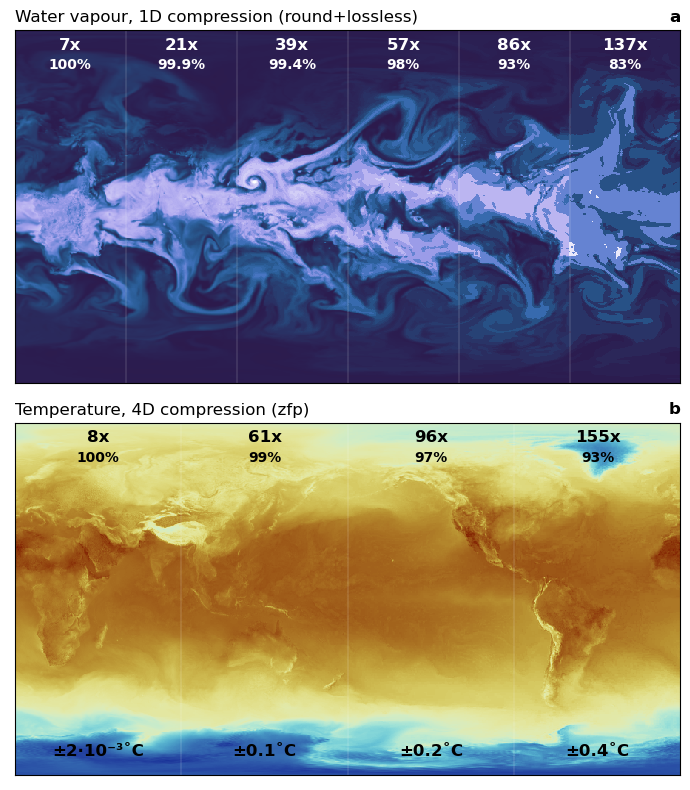

In [88]:
cmap = ColorMap(ColorSchemes.devon.colors)
cmapT = ColorMap(ColorSchemes.roma.colors).reversed()
vmin,vmax = extrema(Xlev)
vminT,vmaxT = extrema(T0lev)

lond = lon_div(length(keepbits_zstd))
londT = lon_div(length(zfp_precision))

fig0,(ax0,ax1) = subplots(2,1,figsize=(7,8),sharex=true,sharey=true)

# round + lossless
for i in 2:length(lond)
    lonwhere = (lon .<= lond[i]) .& (lon .> lond[i-1]-0.5)
    ax0.pcolormesh(lon[lonwhere],lat,round((Xlev),keepbits_zstd[i-1])[lonwhere,:]',
        vmin=vmin,vmax=vmax,cmap=cmap)
end

# zfp
for i in 2:length(londT)
    lonwhere = (lonT .<= londT[i]) .& (lonT .> (londT[i-1]-0.5))
    ax1.pcolormesh(lonT[lonwhere],latT,Tclev[i-1,lonwhere,:]',
        vmin=vminT,vmax=vmaxT,cmap=cmapT)
end

for (i,x) in enumerate(lond[2:end].-lond[2]/2)
    ax0.text(x,70,inf_preserved_str[i]*"%",fontweight="bold",
                fontsize=10,color="white",ha="center")
    c = Int(round(compfacs_zstd[i]))
    ax0.text(x,80,"$(c)x",fontweight="bold",
                fontsize=12,color="white",ha="center")    
end


abserrors = ["±2⋅10⁻³˚C","±0.1˚C","±0.2˚C","±0.4˚C"]
for (i,x) in enumerate(londT[2:end].-londT[2]/2)
    ax1.text(x,70,inf_preservedT[i]*"%",fontweight="bold",
                fontsize=10,color="k",ha="center")
    c = Int(round(compfacs_zfp[i]))
    ax1.text(x,80,"$(c)x",fontweight="bold",
                fontsize=12,color="k",ha="center")
    ax1.text(x,-80,abserrors[i],fontweight="bold",
                fontsize=12,color="k",ha="center")
    
end

# vertical lines
for (i,x) in enumerate(lond[2:end-1])
    ax0.axvline(x,color="w",alpha=0.1)    
end

for (i,x) in enumerate(londT[2:end-1])
    ax1.axvline(x,color="w",alpha=0.1)    
end


ax0.set_title("Water vapour, 1D compression (round+lossless)",loc="left")
ax0.set_title("a",fontweight="bold",loc="right")

ax1.set_title("Temperature, 4D compression (zfp)",loc="left")
ax1.set_title("b",fontweight="bold",loc="right")

ax0.set_xticks([])
ax0.set_yticks([])
tight_layout()

# PLOTTING WITH ROBINSON PROJECTION

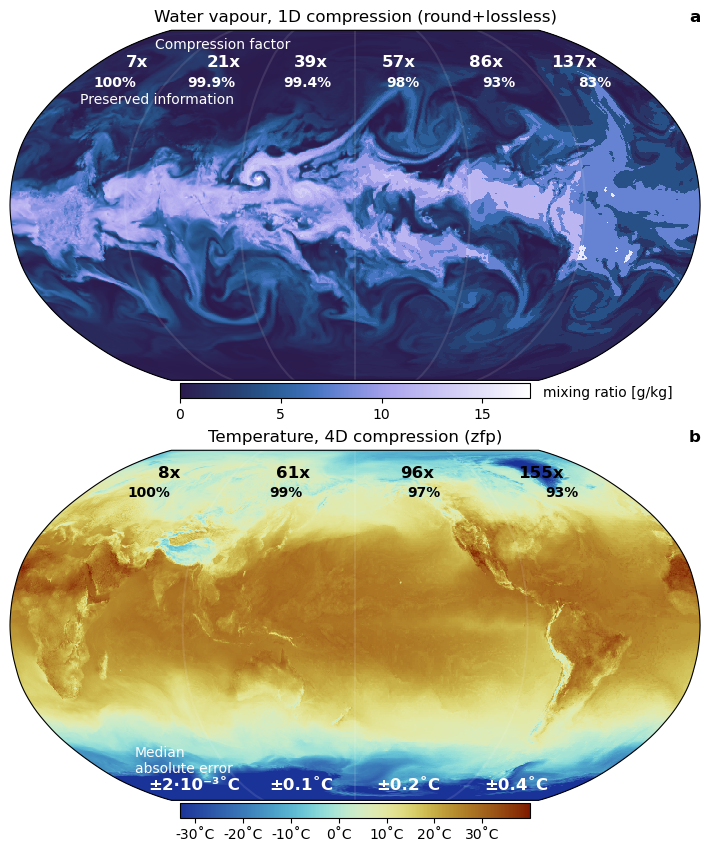

In [89]:
# feature = pyimport("cartopy.feature")

cmap = ColorMap(ColorSchemes.devon.colors)
cmapT = ColorMap(ColorSchemes.roma.colors).reversed()
vmin = 0
vminT = 240
vmax = maximum(Xlev)
vmaxT = maximum(T0lev)

lond = lon_div(length(keepbits_zstd))
londT = lon_div(length(zfp_precision))

fig,(ax0,ax1) = plt.subplots(2,1,figsize=(9,10),sharex=true,sharey=true,
                    subplot_kw=Dict("projection"=>ccrs.Robinson(central_longitude=180)))

pos0 = ax0.get_position()
cax0 = fig.add_axes([pos0.x0,pos0.y0-0.018,pos0.x1-pos0.x0,0.015])

pos1 = ax1.get_position()
cax1 = fig.add_axes([pos1.x0,pos1.y0-0.018,pos1.x1-pos1.x0,0.015])

# round + lossless
for i in 2:length(lond)
    lonwhere = (lon .<= lond[i]) .& (lon .> lond[i-1]-0.5)
    global pcm0 = ax0.pcolormesh(lon[lonwhere],lat,round((Xlev),keepbits_zstd[i-1])[lonwhere,:]',
        vmin=vmin,vmax=vmax,cmap=cmap,transform=ccrs.PlateCarree())
end

# zfp
for i in 2:length(londT)
    lonwhere = (lonT .<= londT[i]) .& (lonT .> (londT[i-1]-0.5))
    global pcm1 = ax1.pcolormesh(lonT[lonwhere],latT,Tclev[i-1,lonwhere,:]',
        vmin=vminT,vmax=vmaxT,cmap=cmapT,transform=ccrs.PlateCarree())
end

scale0 = 1e-3
xtiks0 = collect(0:5:15)
cbar0 = colorbar(pcm0,cax=cax0,orientation="horizontal")
cax0.text(scale0*18,0.002,"mixing ratio [g/kg]")
cbar0.set_ticks(scale0*xtiks0)
cbar0.set_ticklabels(xtiks0)

nullC = 273.15
xtiks = collect(-40:10:40)
cbar1 = colorbar(pcm1,cax=cax1,orientation="horizontal")
cbar1.set_ticks(xtiks .+ nullC)
cbar1.set_ticklabels([string(tik)*"˚C" for tik in xtiks])

# ax0.add_feature(feature.COASTLINE, color=0.5,alpha=.5)
# ax0.coastlines(color=0.5,alpha=.5)
# ax1.coastlines(color=0.2,lw=0.5)

for longi in lond[2:end-1]
    ax0.plot(fill(longi,31),lat_div(31),"w",transform=ccrs.PlateCarree(),alpha=0.1)
end

for longi in londT[2:end-1]
    ax1.plot(fill(longi,31),lat_div(31),"w",transform=ccrs.PlateCarree(),alpha=0.1)
end

tcolor = "w"
ax0.text(25,75,"Compression factor",color=tcolor,
    transform=ccrs.PlateCarree(),fontsize=10)
ax0.text(18,47,"Preserved information",color=tcolor,
    transform=ccrs.PlateCarree(),fontsize=10)

for (i,x) in enumerate(lond[2:end].-lond[2]/2)
    ax0.text(x,55,inf_preserved_str[i]*"%",fontweight="bold",
                fontsize=10,color=tcolor,ha="center",transform=ccrs.PlateCarree())
    c = Int(round(compfacs_zstd[i]))
    ax0.text(x,65,"$(c)x",fontweight="bold",
                fontsize=12,color=tcolor,ha="center",transform=ccrs.PlateCarree())    
end


for (i,x) in enumerate(londT[2:end].-londT[2]/2)
    ax1.text(x,60,inf_preservedT[i]*"%",fontweight="bold",
                fontsize=10,color="k",ha="center",transform=ccrs.PlateCarree())
    c = Int(round(compfacs_zfp[i]))
    ax1.text(x,70,"$(c)x",fontweight="bold",
                fontsize=12,color="k",ha="center",transform=ccrs.PlateCarree())
    ax1.text(x,-80,abserrors[i],fontweight="bold",
                fontsize=12,color=tcolor,ha="center",transform=ccrs.PlateCarree()) 
end
ax1.text(20,-70,"Median\nabsolute error",color=tcolor,
    transform=ccrs.PlateCarree(),fontsize=10)


ax0.set_title("Water vapour, 1D compression (round+lossless)")
ax0.set_title("a",fontweight="bold",loc="right")

ax1.set_title("Temperature, 4D compression (zfp)")
ax1.set_title("b",fontweight="bold",loc="right")

# tight_layout(rect=[0.02,0.08,1,1])
savefig("map_water_temp.png",dpi=100)